In [32]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score

In [1]:
import pandas as pd
import numpy as np
import argparse
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"  # 2. RTX A6000
# gpu setting
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*4)])
    except RuntimeError as e:
        print(e)

2022-12-19 01:35:30.955608: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-12-19 01:35:32.653397: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-19 01:35:32.654289: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-12-19 01:35:32.696998: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:af:00.0 name: NVIDIA RTX A6000 computeCapability: 8.6
coreClock: 1.8GHz coreCount: 84 deviceMemorySize: 47.54GiB deviceMemoryBandwidth: 715.34GiB/s
2022-12-19 01:35:32.697024: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-12-19 01:35:32.699857: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-1

In [25]:
from tensorflow import keras

In [2]:
def get_npy_DbyDeep(df):
    label_enc = {v:k for k, v in enumerate('ZARNDCQEGHILKMFPSTWYV')}  # Z : 0
    pep_data = [[label_enc[aa] for aa in seq] + [0]*(40-len(seq))  # zero padding
               for seq in df.peptide.values]
    nterm_data = [[label_enc[aa] for aa in seq]
               for seq in df.nterm.values]
    cterm_data = [[label_enc[aa] for aa in seq]
               for seq in df.cterm.values]
    miss1_data = [[label_enc[aa] for aa in seq]
               for seq in df.miss1.values]
    miss2_data = [[label_enc[aa] for aa in seq]
               for seq in df.miss2.values]
    return np.array(pep_data), np.array(nterm_data), np.array(cterm_data), np.array(miss1_data), np.array(miss2_data), np.array(df.label.values)

In [11]:
def build_model():
    # Peptide Sequence Representation Module
    peptide_embedding_matrix = tf.keras.layers.Embedding(21, 16, input_length=40, mask_zero=True)
    peptide_rnn = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))
    drop_out = tf.keras.layers.Dropout(np.random.uniform(0, 0.4))

    pep = tf.keras.layers.Input(shape=((40,)))
    pep_embed = peptide_embedding_matrix(pep)
    pep_lstm = peptide_rnn(pep_embed)
    pep_lstm = drop_out(pep_lstm)

    # Cleavage Sites Representation Module
    trypsin_site_embedding_marix = tf.keras.layers.Embedding(21, 16, input_length=15, mask_zero=True)
    trypsin_site_rnn = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))
    n = tf.keras.layers.Input(shape=((15,)))
    n_embed = trypsin_site_embedding_marix(n)
    n_lstm = trypsin_site_rnn(n_embed)
    n_lstm = drop_out(n_lstm)
    c = tf.keras.layers.Input(shape=((15,)))
    c_embed = trypsin_site_embedding_marix(c)
    c_lstm = trypsin_site_rnn(c_embed)
    c_lstm = drop_out(c_lstm)
    m1 = tf.keras.layers.Input(shape=((15,)))
    m1_embed = trypsin_site_embedding_marix(m1)
    m1_lstm = trypsin_site_rnn(m1_embed)
    m1_lstm = drop_out(m1_lstm)
    m2 = tf.keras.layers.Input(shape=((15,)))
    m2_embed = trypsin_site_embedding_marix(m2)
    m2_lstm = trypsin_site_rnn(m2_embed)
    m2_lstm = drop_out(m2_lstm)

    merge = tf.keras.layers.concatenate([pep_lstm, 
                                     n_lstm,
                                     c_lstm,
                                     m1_lstm,
                                     m2_lstm])
    net_merge = tf.keras.layers.Dense(64, activation='relu')(merge)
    net_merge = drop_out(net_merge)
    output = tf.keras.layers.Dense(1, activation = 'sigmoid')(net_merge)

    model = tf.keras.Model(inputs=[pep, n, c, m1, m2], outputs=[output])

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  optimizer=tf.keras.optimizers.Adam(1e-3),
                  metrics=['accuracy'])
    return model


def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.title(metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

In [12]:
def main(train_file_path, version):
    # train test split
    train = pd.read_csv(train_file_path)
    train, val = train_test_split(train, test_size=0.2, random_state=7)
    pep_train, n_train, c_train, m1_train, m2_train, label_train = get_npy_DbyDeep(train)
    pep_val, n_val, c_val, m1_val, m2_val, label_val = get_npy_DbyDeep(val)
    print(pep_train.shape, n_train.shape, c_train.shape, m1_train.shape, m2_train.shape, label_train.shape)

    # train
    model = build_model()
    print(model.summary())
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                          mode='min', 
                                          verbose=1,
                                          patience=50)
    cp = tf.keras.callbacks.ModelCheckpoint(
        f'log/model_DbyDeep_{version}.h5',
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False, 
        mode='auto', 
        period=1)

    history = model.fit([pep_train, n_train, c_train, m1_train, m2_train], label_train,
                        epochs=200,
                        batch_size=256,

                        validation_data=([pep_val, n_val, c_val, m1_val, m2_val], label_val),
                        callbacks=[es, cp],
                        )
    np.save(f'log/log_DbyDeep_history_{version}.npy', history.history)
    plt.figure(figsize=(16,2))
    plt.subplot(1,2,1)
    plot_graphs(history, 'accuracy')
    plt.subplot(1,2,2)
    plot_graphs(history, 'loss')
    plt.savefig(f'log/log_DbyDeep_plot_{version}.png', bbox_inches='tight')

In [ ]:
if __name__ == '__main__':
    main(
        '/data/2021_SJH_detectability/data_human/train.csv', 
        '06'
    )

(535993, 40) (535993, 15) (535993, 15) (535993, 15) (535993, 15) (535993,)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 15)]         0                                            
___________________

2022-12-19 02:05:31.372236: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-12-19 02:05:31.391284: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3000000000 Hz


Epoch 1/200


2022-12-19 02:05:53.535180: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-12-19 02:05:54.285235: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-12-19 02:05:54.492408: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2022-12-19 02:05:56.600193: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2094/2094 [==============================] - 273s 117ms/step - loss: 0.4864 - accuracy: 0.7651 - val_loss: 0.4213 - val_accuracy: 0.8046
Epoch 2/200
2094/2094 [==============================] - 212s 101ms/step - loss: 0.4123 - accuracy: 0.8101 - val_loss: 0.3986 - val_accuracy: 0.8180
Epoch 3/200
2094/2094 [==============================] - 204s 97ms/step - loss: 0.3970 - accuracy: 0.8190 - val_loss: 0.3924 - val_accuracy: 0.8227
Epoch 4/200
2094/2094 [==============================] - 206s 98ms/step - loss: 0.3921 - accuracy: 0.8209 - val_loss: 0.3858 - val_accuracy: 0.8259
Epoch 5/200
2094/2094 [==============================] - 206s 98ms/step - loss: 0.3853 - accuracy: 0.8253 - val_loss: 0.3836 - val_accuracy: 0.8269
Epoch 6/200
2094/2094 [==============================] - 205s 98ms/step - loss: 0.3827 - accuracy: 0.8268 - val_loss: 0.3777 - val_accuracy: 0.8298
Epoch 7/200
2094/2094 [==============================] - 206s 99ms/step - loss: 0.3781 - accuracy: 0.8294 - val_loss: 0.37

# HPP

In [26]:
print('Loading model...')
model = keras.models.load_model("log/model_DbyDeep_06.h5")
model.summary()

Loading model...
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 15)]         0                                            
_____________________________________________________________________________

In [27]:
df_hpp = pd.read_csv('/data/2021_SJH_detectability/data_human/HPP.csv')
df_hpp.rename({'Class':'label'}, axis=1, inplace=True)

In [28]:
print('Loading input peptides')
pep_hpp, n_hpp, c_hpp, m1_hpp, m2_hpp, label_hpp = get_npy_DbyDeep(df_hpp)

print('Making predictions')
model_pred = model.predict([pep_hpp, n_hpp, c_hpp, m1_hpp, m2_hpp])

Loading input peptides
Making predictions


In [29]:
df_hpp = pd.concat([df_hpp, pd.DataFrame(model_pred, columns=['probs'])['probs']], axis=1)

pe = df_hpp.loc[df_hpp['label']=='PE1'][['peptide', 'probs']].drop_duplicates()
dmp = df_hpp.loc[df_hpp['label']=='Detected_MPs'][['peptide', 'probs']].drop_duplicates()
mp = df_hpp.loc[df_hpp['label']=='MPs'][['peptide', 'probs']].drop_duplicates()

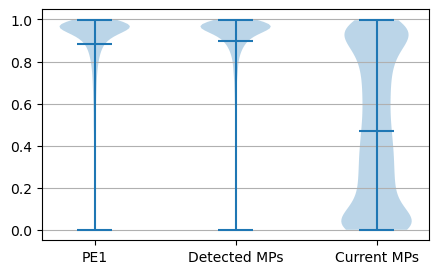

In [30]:
plt.figure(figsize=(5,3))
a = plt.violinplot([pe.probs.astype(float), 
                    dmp.probs.astype(float), 
                    mp.probs.astype(float)],
               showmeans=True,
              )
plt.xticks([y + 1 for y in range(len([pe,dmp,mp]))], ['PE1', 'Detected MPs', 'Current MPs'])
b = plt.grid(axis='y')
plt.show()

In [34]:
import seaborn as sns

TEST Accuracy : 0.8453143127228978
TEST AUC : 0.8543927787020447
              precision    recall  f1-score   support

           0     0.8233    0.5380    0.6508      6234
           1     0.8500    0.9577    0.9007     17039

    accuracy                         0.8453     23273
   macro avg     0.8366    0.7479    0.7757     23273
weighted avg     0.8428    0.8453    0.8337     23273



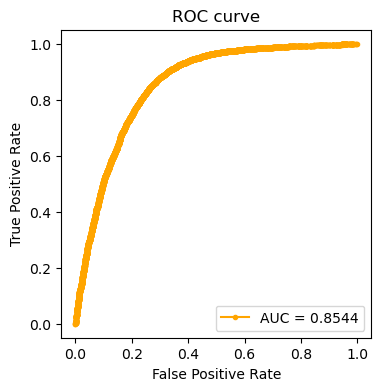

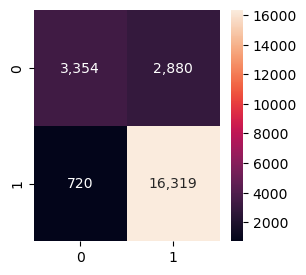

In [35]:
hpp_prob = np.concatenate([pe.probs.values, dmp.probs.values, mp.probs.values])
hpp_pred = np.array([1 if _ >= 0.5 else 0 for _ in hpp_prob])
hpp_true = np.array([1]*len(pe) + [1]*len(dmp) + [0]*len(mp))

auc = roc_auc_score(hpp_true, hpp_prob)
acc = accuracy_score(hpp_true,hpp_pred)
print('TEST Accuracy : {}'.format(acc))
print('TEST AUC : {}'.format(auc))
print(classification_report(hpp_true, hpp_pred, digits=4))


plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(hpp_true, hpp_prob)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(hpp_true, hpp_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

# massIVE-KB

In [36]:
df_test = pd.read_csv('/data/2021_SJH_detectability/data_human/test.csv')

In [37]:
print('Loading input peptides')
pep_test, n_test, c_test, m1_test, m2_test, label_test = get_npy_DbyDeep(df_test)

Loading input peptides


In [38]:
probs = model.predict([pep_test, n_test, c_test, m1_test, m2_test])
y_pred = [1 if i>=0.5 else 0 for i in probs]
loss, acc = model.evaluate([pep_test, n_test, c_test, m1_test, m2_test], label_test)
auc = roc_auc_score(label_test, probs)

5335/5335 [==============================] - 101s 17ms/step - loss: 0.3536 - accuracy: 0.8431


Test Loss: 0.35359591245651245
Test Accuracy: 0.8430517911911011
Test AUC : 0.9224511271555278
              precision    recall  f1-score   support

       False     0.8442    0.8465    0.8453     86495
        True     0.8419    0.8395    0.8407     84211

    accuracy                         0.8431    170706
   macro avg     0.8430    0.8430    0.8430    170706
weighted avg     0.8430    0.8431    0.8430    170706



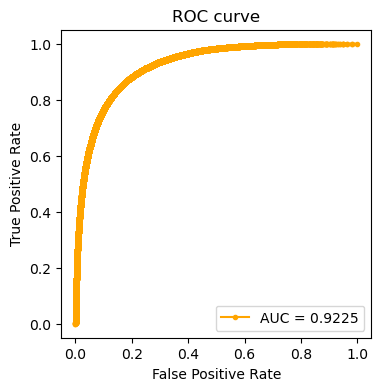

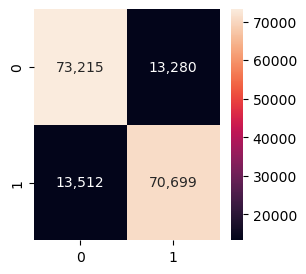

In [39]:
print('Test Loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(label_test, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, _ = roc_curve(label_test, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(label_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

# Case of missed cleavage sites count

Test AUC : 0.8990067155294313
              precision    recall  f1-score   support

       False     0.8119    0.6130    0.6986     10970
        True     0.9006    0.9611    0.9298     40007

    accuracy                         0.8862     50977
   macro avg     0.8562    0.7870    0.8142     50977
weighted avg     0.8815    0.8862    0.8801     50977



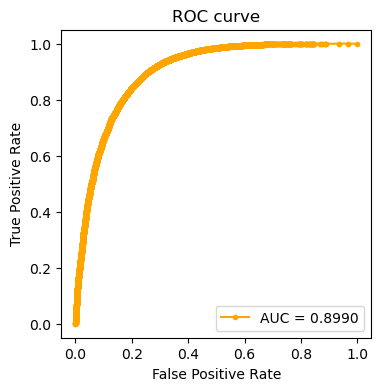

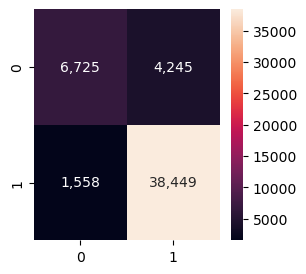

Test AUC : 0.8755389023494853
              precision    recall  f1-score   support

       False     0.7847    0.7893    0.7870     31745
        True     0.7976    0.7932    0.7954     33229

    accuracy                         0.7913     64974
   macro avg     0.7911    0.7912    0.7912     64974
weighted avg     0.7913    0.7913    0.7913     64974



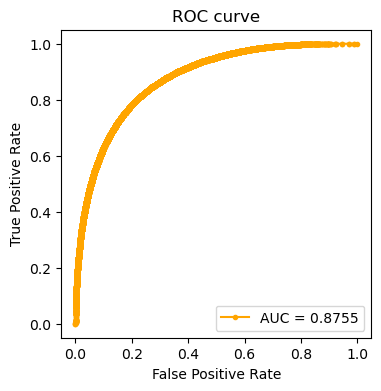

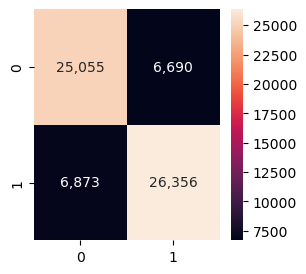

Test AUC : 0.8946392534217993
              precision    recall  f1-score   support

       False     0.8908    0.9464    0.9178     43780
        True     0.7154    0.5370    0.6135     10975

    accuracy                         0.8644     54755
   macro avg     0.8031    0.7417    0.7656     54755
weighted avg     0.8556    0.8644    0.8568     54755



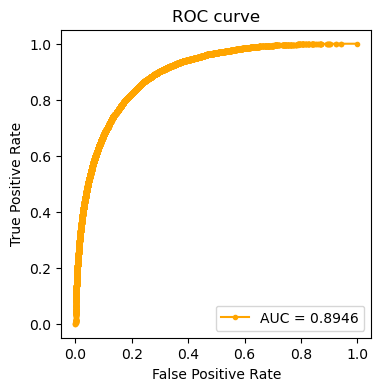

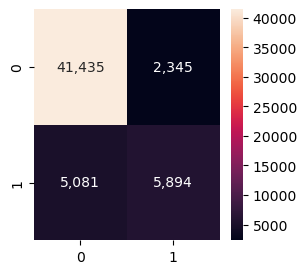

In [40]:
miss0_idx = df_test.loc[df_test.miss1=='ZZZZZZZZZZZZZZZ'].index
miss1_idx = df_test.loc[(df_test.miss1!='ZZZZZZZZZZZZZZZ') & (df_test.miss2=='ZZZZZZZZZZZZZZZ')].index
miss2_idx = df_test.loc[(df_test.miss1!='ZZZZZZZZZZZZZZZ') & (df_test.miss2!='ZZZZZZZZZZZZZZZ')].index

y_pred = np.array(y_pred)
probs_miss0 = probs[miss0_idx]
probs_miss1 = probs[miss1_idx]
probs_miss2 = probs[miss2_idx]
y_pred_miss0 = y_pred[miss0_idx]
y_pred_miss1 = y_pred[miss1_idx]
y_pred_miss2 = y_pred[miss2_idx]
label_test_miss0 = label_test[miss0_idx]
label_test_miss1 = label_test[miss1_idx]
label_test_miss2 = label_test[miss2_idx]

auc = roc_auc_score(label_test_miss0, probs_miss0)
print('Test AUC : {}'.format(auc))
print(classification_report(label_test_miss0, y_pred_miss0, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, _ = roc_curve(label_test_miss0, probs_miss0)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(label_test_miss0, y_pred_miss0)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

auc = roc_auc_score(label_test_miss1, probs_miss1)
print('Test AUC : {}'.format(auc))
print(classification_report(label_test_miss1, y_pred_miss1, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, _ = roc_curve(label_test_miss1, probs_miss1)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(label_test_miss1, y_pred_miss1)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

auc = roc_auc_score(label_test_miss2, probs_miss2)
print('Test AUC : {}'.format(auc))
print(classification_report(label_test_miss2, y_pred_miss2, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, _ = roc_curve(label_test_miss2, probs_miss2)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(label_test_miss2, y_pred_miss2)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()



# Cross Species - Mouse

Loading input peptides
47321/47321 [==============================] - 759s 16ms/step - loss: 0.7372 - accuracy: 0.6850
Test Loss: 0.7372460961341858
Test Accuracy: 0.6850436925888062
Test AUC : 0.907036395303894
              precision    recall  f1-score   support

       False     0.9961    0.6707    0.8016   1436847
        True     0.1347    0.9518    0.2361     77417

    accuracy                         0.6850   1514264
   macro avg     0.5654    0.8112    0.5188   1514264
weighted avg     0.9521    0.6850    0.7727   1514264



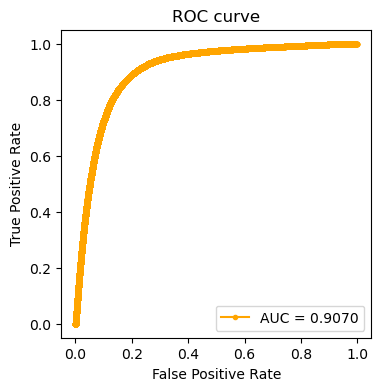

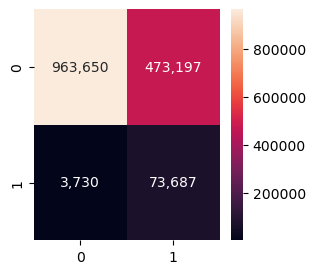

In [41]:
df_test = pd.concat([
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/mouse/KLife/train.csv'),
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/mouse/KLife/test.csv'),
])
df_test = df_test[df_test.peptide.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.nterm.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.cterm.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.miss1.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.miss2.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.peptide.apply(lambda x: 'Z' not in x)].reset_index(drop=True)

print('Loading input peptides')
pep_test, n_test, c_test, m1_test, m2_test, label_test = get_npy_DbyDeep(df_test)

probs = model.predict([pep_test, n_test, c_test, m1_test, m2_test])
y_pred = [1 if i>=0.5 else 0 for i in probs]
loss, acc = model.evaluate([pep_test, n_test, c_test, m1_test, m2_test], label_test)
auc = roc_auc_score(label_test, probs)

print('Test Loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(label_test, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(label_test, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(label_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

Loading input peptides
41477/41477 [==============================] - 665s 16ms/step - loss: 0.7568 - accuracy: 0.6812
Test Loss: 0.7567684650421143
Test Accuracy: 0.6811699867248535
Test AUC : 0.8846574147153285
              precision    recall  f1-score   support

       False     0.9948    0.6671    0.7986   1257916
        True     0.1343    0.9370    0.2349     69343

    accuracy                         0.6812   1327259
   macro avg     0.5646    0.8020    0.5168   1327259
weighted avg     0.9499    0.6812    0.7692   1327259



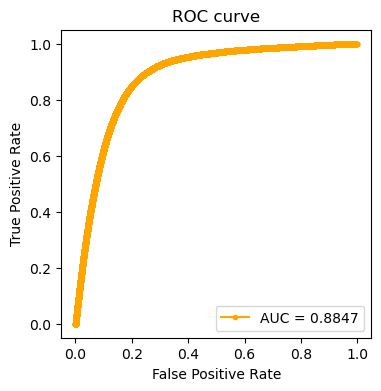

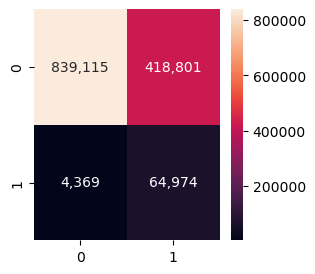

In [42]:
df_test = pd.concat([
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/mouse/SkeletaMuscle/train.csv'),
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/mouse/SkeletaMuscle/test.csv'),
])
df_test = df_test[df_test.peptide.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.nterm.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.cterm.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.miss1.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.miss2.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.peptide.apply(lambda x: 'Z' not in x)].reset_index(drop=True)

print('Loading input peptides')
pep_test, n_test, c_test, m1_test, m2_test, label_test = get_npy_DbyDeep(df_test)

probs = model.predict([pep_test, n_test, c_test, m1_test, m2_test])
y_pred = [1 if i>=0.5 else 0 for i in probs]
loss, acc = model.evaluate([pep_test, n_test, c_test, m1_test, m2_test], label_test)
auc = roc_auc_score(label_test, probs)

print('Test Loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(label_test, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(label_test, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(label_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

# Cross Species - Human

Loading input peptides
62371/62371 [==============================] - 1000s 16ms/step - loss: 0.7050 - accuracy: 0.6989
Test Loss: 0.7049602270126343
Test Accuracy: 0.6989177465438843
Test AUC : 0.881110226805649
              precision    recall  f1-score   support

       False     0.9919    0.6830    0.8090   1862789
        True     0.1720    0.9220    0.2899    133071

    accuracy                         0.6989   1995860
   macro avg     0.5820    0.8025    0.5494   1995860
weighted avg     0.9372    0.6989    0.7744   1995860



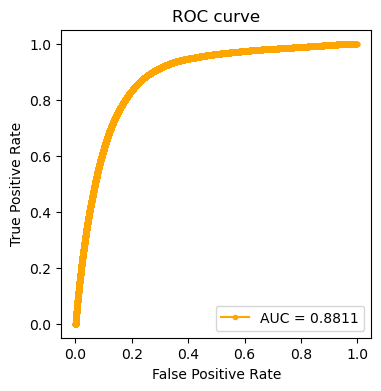

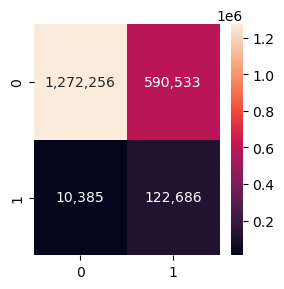

In [43]:
df_test = pd.concat([
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/human/HEK293/train.csv'),
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/human/HEK293/test.csv'),
])

print('Loading input peptides')
pep_test, n_test, c_test, m1_test, m2_test, label_test = get_npy_DbyDeep(df_test)

probs = model.predict([pep_test, n_test, c_test, m1_test, m2_test])
y_pred = [1 if i>=0.5 else 0 for i in probs]
loss, acc = model.evaluate([pep_test, n_test, c_test, m1_test, m2_test], label_test)
auc = roc_auc_score(label_test, probs)

print('Test Loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(label_test, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(label_test, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(label_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

Loading input peptides
46799/46799 [==============================] - 748s 16ms/step - loss: 0.7934 - accuracy: 0.6666
Test Loss: 0.7933762073516846
Test Accuracy: 0.6665618419647217
Test AUC : 0.8554034112882498
              precision    recall  f1-score   support

       False     0.9932    0.6580    0.7916   1441079
        True     0.0920    0.8846    0.1667     56470

    accuracy                         0.6666   1497549
   macro avg     0.5426    0.7713    0.4792   1497549
weighted avg     0.9592    0.6666    0.7680   1497549



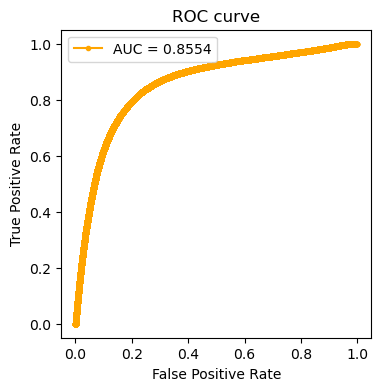

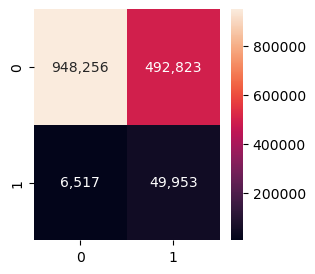

In [44]:
df_test = pd.concat([
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/human/HmapLiver/train.csv'),
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/human/HmapLiver/test.csv'),
])

print('Loading input peptides')
pep_test, n_test, c_test, m1_test, m2_test, label_test = get_npy_DbyDeep(df_test)

probs = model.predict([pep_test, n_test, c_test, m1_test, m2_test])
y_pred = [1 if i>=0.5 else 0 for i in probs]
loss, acc = model.evaluate([pep_test, n_test, c_test, m1_test, m2_test], label_test)
auc = roc_auc_score(label_test, probs)

print('Test Loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(label_test, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(label_test, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(label_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

# Cross Species - Yeast

Loading input peptides
17349/17349 [==============================] - 283s 16ms/step - loss: 0.7930 - accuracy: 0.6693
Test Loss: 0.7929806709289551
Test Accuracy: 0.6693122386932373
Test AUC : 0.8731310815593559
              precision    recall  f1-score   support

       False     0.9930    0.6529    0.7878    521986
        True     0.1451    0.9271    0.2509     33160

    accuracy                         0.6693    555146
   macro avg     0.5690    0.7900    0.5194    555146
weighted avg     0.9423    0.6693    0.7558    555146



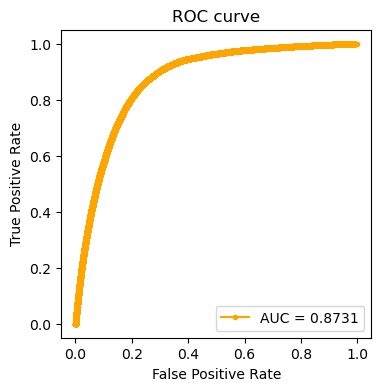

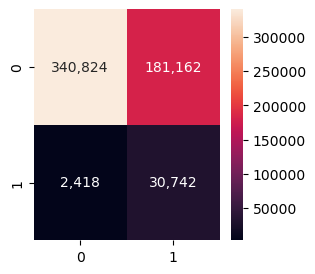

In [45]:
df_test = pd.concat([
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/yeast/DelPBP1/train.csv'),
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/yeast/DelPBP1/test.csv'),
])
df_test = df_test[df_test.peptide.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.nterm.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.cterm.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.miss1.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.miss2.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.peptide.apply(lambda x: 'Z' not in x)].reset_index(drop=True)

print('Loading input peptides')
pep_test, n_test, c_test, m1_test, m2_test, label_test = get_npy_DbyDeep(df_test)

probs = model.predict([pep_test, n_test, c_test, m1_test, m2_test])
y_pred = [1 if i>=0.5 else 0 for i in probs]
loss, acc = model.evaluate([pep_test, n_test, c_test, m1_test, m2_test], label_test)
auc = roc_auc_score(label_test, probs)

print('Test Loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(label_test, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(label_test, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(label_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

Loading input peptides
20044/20044 [==============================] - 341s 17ms/step - loss: 0.6168 - accuracy: 0.7265
Test Loss: 0.6167900562286377
Test Accuracy: 0.7264941930770874
Test AUC : 0.9068944237967161
              precision    recall  f1-score   support

       False     0.9860    0.6983    0.8176    562874
        True     0.3004    0.9287    0.4540     78520

    accuracy                         0.7265    641394
   macro avg     0.6432    0.8135    0.6358    641394
weighted avg     0.9020    0.7265    0.7730    641394



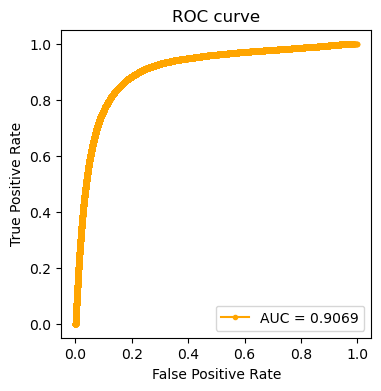

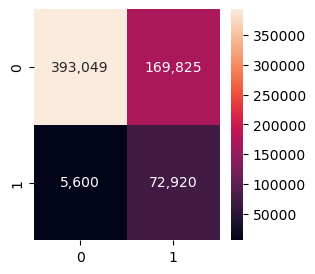

In [46]:
df_test = pd.concat([
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/yeast/KLife/train.csv'),
    pd.read_csv('/data/2021_SJH_detectability/data_cross_species/raw/yeast/KLife/test.csv'),
])
df_test = df_test[df_test.peptide.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.nterm.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.cterm.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.miss1.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.miss2.apply(lambda x: 'B' not in x)].reset_index(drop=True)
df_test = df_test[df_test.peptide.apply(lambda x: 'Z' not in x)].reset_index(drop=True)

print('Loading input peptides')
pep_test, n_test, c_test, m1_test, m2_test, label_test = get_npy_DbyDeep(df_test)

probs = model.predict([pep_test, n_test, c_test, m1_test, m2_test])
y_pred = [1 if i>=0.5 else 0 for i in probs]
loss, acc = model.evaluate([pep_test, n_test, c_test, m1_test, m2_test], label_test)
auc = roc_auc_score(label_test, probs)

print('Test Loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(label_test, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, threshold = roc_curve(label_test, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(label_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()